In [112]:
# Import pandas
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from imp import reload
%matplotlib inline

In [113]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [114]:
# Read in dataset
df = pd.read_csv('training.csv')
df_copy = df.copy()
# Print out the first rows of our dataset
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [115]:
df.drop('ID', axis =1, inplace=True)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Gender               245725 non-null  object
 1   Age                  245725 non-null  int64 
 2   Region_Code          245725 non-null  object
 3   Occupation           245725 non-null  object
 4   Channel_Code         245725 non-null  object
 5   Vintage              245725 non-null  int64 
 6   Credit_Product       216400 non-null  object
 7   Avg_Account_Balance  245725 non-null  int64 
 8   Is_Active            245725 non-null  object
 9   Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 18.7+ MB


In [117]:
df.isnull().sum()

Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

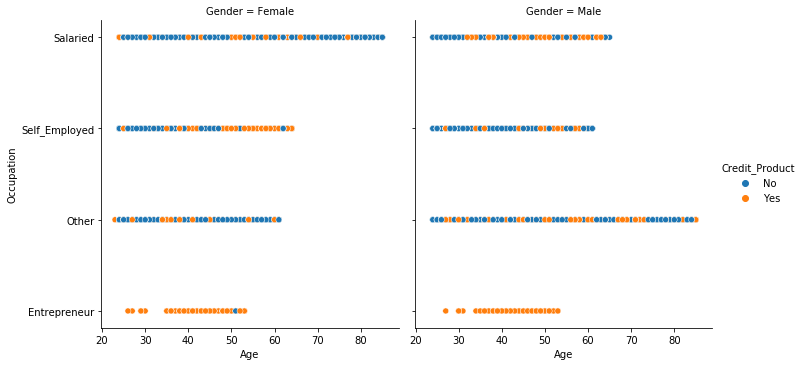

In [118]:
sns.relplot(x= 'Age', y = 'Occupation', data =df, col= 'Gender', hue='Credit_Product')

In [119]:
df.loc[df['Occupation']=='Entrepreneur', 'Credit_Product'] = df.loc[df['Occupation']=='Entrepreneur', 'Credit_Product'].fillna('Yes')

In [120]:
#Region_Code modification
df['Region_Code'] = df['Region_Code'].str.replace(r'RG', '')
df['Region_Code']= df['Region_Code'].astype(float)

In [121]:
age_bins = np.arange(20, 90, 5).tolist()
age_bins.insert(0, 0)
age_bins.append(100)
age_labels = [(str(age_bins[x-1])+'-'+str(age_bins[x]-1)) for x in range(1, len(age_bins))]
df['AgeBin'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

In [122]:
#Up to 14 years
vintage_bins = np.arange(1, 180, 12).tolist()
vintage_labels = [(str(vintage_bins[x-1])+'-'+str(vintage_bins[x]-1)) for x in range(1, len(vintage_bins))]
df['VintageBin'] = pd.cut(df['Vintage'], bins=vintage_bins, labels=vintage_labels, right=False)

In [123]:
region_bins = np.arange(250, 290, 5).tolist()
region_labels = [(str(region_bins[x-1])+'-'+str(region_bins[x]-1)) for x in range(1, len(region_bins))]
df['RegionBin'] = pd.cut(df['Region_Code'], bins=region_bins, labels=region_labels, right=False)
df.drop('Region_Code', inplace = True, axis =1)  

In [124]:
def labelencoder(df, col_lab):
    for i in col_lab:
        lab= LabelEncoder()
        lab.fit(df[i])
        df[i]=pd.DataFrame(lab.transform(df[i]))
        
    return df

col_lab= ['Gender', 'Occupation', 'Channel_Code',
        'Is_Active','AgeBin', 'RegionBin','VintageBin']
df = labelencoder(df, col_lab)

In [125]:
Y = df['Is_Lead']  
target = df['Is_Lead']  
X= df.drop(['Is_Lead'], axis =1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=60,
    stratify=Y
)

In [126]:
def transform(df,col1, col2):
    for i in col1:
        for j in col2:
            df[i + '__mean__'+ j] =  df.groupby(i)[j].transform('mean')
            #df[i + '__std__'+ j] = ( df[j] - df[i + '__mean__'+ j]  ) / df.groupby(i)[j].transform('std')
            
    df.drop(col2, inplace = True, axis =1)        
            
    return df

col1= ['Gender','Occupation','Channel_Code','Credit_Product','Is_Active','RegionBin']
col2 = ['Age','Vintage','Avg_Account_Balance']

In [127]:
X_train = transform(X_train,col1,col2)
 = transform(X_test,col1,col2)

C:\Users\Ryuk\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Ryuk\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [129]:
credit_col = ['Credit_Product__mean__Age','Credit_Product__mean__Vintage','Credit_Product__mean__Avg_Account_Balance']
X_train.loc[:,credit_col]= X_train.loc[:,credit_col].apply(lambda x: x.fillna(x.mean()),axis=0)
X_test.loc[:,credit_col]= X_test.loc[:,credit_col].apply(lambda x: x.fillna(x.mean()),axis=0)

C:\Users\Ryuk\anaconda3\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [131]:
X_train['Credit_Product'] = X_train['Credit_Product'].map({'No':0, 'Yes':1})
X_train['Credit_Product'].fillna(-999, inplace = True)

X_test['Credit_Product'] = X_test['Credit_Product'].map({'No':0, 'Yes':1})
X_test['Credit_Product'].fillna(-999, inplace = True)

C:\Users\Ryuk\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ryuk\anaconda3\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\Ryuk\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [132]:
X_train

,Gender,Occupation,Channel_Code,Credit_Product,Is_Active,AgeBin,VintageBin,RegionBin,Gender__mean__Age,Gender__mean__Vintage,...,Channel_Code__mean__Avg_Account_Balance,Credit_Product__mean__Age,Credit_Product__mean__Vintage,Credit_Product__mean__Avg_Account_Balance,Is_Active__mean__Age,Is_Active__mean__Vintage,Is_Active__mean__Avg_Account_Balance,RegionBin__mean__Age,RegionBin__mean__Vintage,RegionBin__mean__Avg_Account_Balance
2314,0,1,0,1.0,0,2,5,4,41.362831,41.762063,...,1.030363e+06,46.807559,51.985530,1.189521e+06,41.26971,41.517721,1.077076e+06,39.581697,36.200698,8.336523e+05
174951,0,1,0,0.0,1,10,9,6,41.362831,41.762063,...,1.030363e+06,40.801135,40.538548,1.077352e+06,47.90608,55.473199,1.206419e+06,46.690032,53.349870,1.266247e+06
72152,1,3,2,0.0,1,5,7,0,45.927376,51.271703,...,1.274137e+06,40.801135,40.538548,1.077352e+06,47.90608,55.473199,1.206419e+06,42.621847,44.244144,1.190742e+06
80192,0,3,1,1.0,0,4,3,6,41.362831,41.762063,...,1.139505e+06,46.807559,51.985530,1.189521e+06,41.26971,41.517721,1.077076e+06,46.690032,53.349870,1.266247e+06
204196,0,2,0,0.0,1,1,0,0,41.362831,41.762063,...,1.030363e+06,40.801135,40.538548,1.077352e+06,47.90608,55.473199,1.206419e+06,42.621847,44.244144,1.190742e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85541,0,2,0,0.0,0,0,3,4,41.362831,41.762063,...,1.030363e+06,40.801135,40.538548,1.077352e+06,41.26971,41.517721,1.077076e+06,39.581697,36.200698,8.336523e+05
21246,1,2,0,1.0,0,1,3,3,45.927376,51.271703,...,1.030363e+06,46.807559,51.985530,1.189521e+06,41.26971,41.517721,1.077076e+06,46.992616,54.375572,1.323505e+06
223131,1,2,2,-999.0,1,5,9,0,45.927376,51.271703,...,1.274137e+06,42.822232,44.390335,1.115096e+06,47.90608,55.473199,1.206419e+06,42.621847,44.244144,1.190742e+06
29805,0,2,2,-999.0,0,5,10,0,41.362831,41.762063,...,1.274137e+06,42.822232,44.390335,1.115096e+06,41.26971,41.517721,1.077076e+06,42.621847,44.244144,1.190742e+06


In [133]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=600, random_state=2, verbose = 200) 
model.fit(X_train, y_train) 
predictions = model.predict_proba(X_test)[:, 1]
accuracy = roc_auc_score(y_test, predictions)
accuracy


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 600
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
building tree 2 of 600
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
building tree 3 of 600
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
building tree 4 of 600
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s
building tree 5 of 600
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s remaining:    0.0s
building tree 6 of 600
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.8s remaining:    0.0s
building tree 7 of 600
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.2s remaining:    0.0s
building tree 8 of 600
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.0s remaining:    0.0s
building tree 9 of 600
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.2s remaining: 

[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  1.1min remaining:    0.0s
building tree 80 of 600
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.1min remaining:    0.0s
building tree 81 of 600
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.1min remaining:    0.0s
building tree 82 of 600
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:  1.1min remaining:    0.0s
building tree 83 of 600
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:  1.1min remaining:    0.0s
building tree 84 of 600
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  1.2min remaining:    0.0s
building tree 85 of 600
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  1.2min remaining:    0.0s
building tree 86 of 600
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:  1.2min remaining:    0.0s
building tree 87 of 600
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:  1.2min remaining:    0.0s
building tree 88 of 600
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:  1.2min rem

[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed:  2.3min remaining:    0.0s
building tree 159 of 600
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:  2.4min remaining:    0.0s
building tree 160 of 600
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.4min remaining:    0.0s
building tree 161 of 600
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:  2.4min remaining:    0.0s
building tree 162 of 600
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  2.4min remaining:    0.0s
building tree 163 of 600
[Parallel(n_jobs=1)]: Done 163 out of 163 | elapsed:  2.4min remaining:    0.0s
building tree 164 of 600
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:  2.4min remaining:    0.0s
building tree 165 of 600
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  2.5min remaining:    0.0s
building tree 166 of 600
[Parallel(n_jobs=1)]: Done 166 out of 166 | elapsed:  2.5min remaining:    0.0s
building tree 167 of 600
[Parallel(n_jobs=1)]: Done 167 out of 167 | elapsed:  2

building tree 353 of 600
building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600
building tree 384 of 600
building tree 385 of 600
building tree 386 of 600
building tree 387 of 600
building tree 388 of 600
building tree 389 of 600
building tree 390 of 600
building tree 391 of 600
building tree 392 of 600


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  3

[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 133 out of 133 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 136 out of 136 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 139 out of 139 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 140 out of 14

0.8401284198298198

In [134]:
#catboost model training
from catboost import CatBoostClassifier

model = CatBoostClassifier(n_estimators = 1600,
                       learning_rate = 0.02,
                       random_state=2054,
                       rsm = 0.4,
                       verbose=200
                       )
model.fit(X_train, y_train) 
predictions = model.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test,predictions)
print("ROC for validation set is {}".format(roc_score))

0:	learn: 0.6760160	total: 155ms	remaining: 4m 7s
200:	learn: 0.3459393	total: 28.5s	remaining: 3m 18s
400:	learn: 0.3432680	total: 59.3s	remaining: 2m 57s
600:	learn: 0.3421187	total: 1m 38s	remaining: 2m 44s
800:	learn: 0.3411165	total: 2m 17s	remaining: 2m 17s
1000:	learn: 0.3402683	total: 2m 56s	remaining: 1m 45s
1200:	learn: 0.3395491	total: 3m 31s	remaining: 1m 10s
1400:	learn: 0.3388825	total: 4m 11s	remaining: 35.8s
1599:	learn: 0.3382839	total: 4m 51s	remaining: 0us
ROC for validation set is 0.872199704143225


In [72]:
from sklearn.model_selection import StratifiedKFold

In [70]:
#Function for running cross validation
def run_gradient_boosting(clf, fit_params, train, features):
  N_SPLITS = 10
  oofs = np.zeros(len(train))
  

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['Is_Lead'])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    
#     scaler = StandardScaler()
#     _ = scaler.fit(X_trn)

#     X_trn = scaler.transform(X_trn)
#     X_val = scaler.transform(X_val)
#     X_test = scaler.transform(X_test)
    
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    

    roc_score = roc_auc_score(y_val,preds_val)
    print("ROC for validation set is {}".format(roc_score))

    oofs[val_idx] = preds_val
    


  oofs_score = roc_auc_score(target, oofs.round())
  print('ROC score for oofs is {}'.format(oofs_score))
  

  return oofs

In [77]:
#catboost model training
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.02,
                       rsm = 0.4, 
                       random_state=2054,
                       
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 300}

cb_oofs= run_gradient_boosting(clf, fit_params, df,  X_train.columns)

optimized_roc = roc_auc_score( target, (cb_oofs  * 1))
print(f'Optimized ROC is {optimized_roc}')


------------- Fold 1 -------------
0:	learn: 0.6759205	test: 0.6759947	best: 0.6759947 (0)	total: 69.5ms	remaining: 3m 28s
200:	learn: 0.3531572	test: 0.3555564	best: 0.3555564 (200)	total: 18s	remaining: 4m 10s
400:	learn: 0.3512274	test: 0.3539675	best: 0.3539675 (400)	total: 35.9s	remaining: 3m 52s
600:	learn: 0.3504053	test: 0.3536037	best: 0.3536037 (600)	total: 51.7s	remaining: 3m 26s
800:	learn: 0.3496578	test: 0.3533918	best: 0.3533918 (800)	total: 1m 5s	remaining: 3m
1000:	learn: 0.3490029	test: 0.3533415	best: 0.3533383 (999)	total: 1m 21s	remaining: 2m 41s
1200:	learn: 0.3483774	test: 0.3533676	best: 0.3533257 (1033)	total: 1m 34s	remaining: 2m 20s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.3533256951
bestIteration = 1033

Shrink model to first 1034 iterations.
ROC for validation set is 0.8650817349445686

------------- Fold 2 -------------
0:	learn: 0.6759215	test: 0.6759236	best: 0.6759236 (0)	total: 72.1ms	remaining: 3m 36s
200:	learn: 0.3533475